#  Simple tool to analyze data from https://data.europa.eu/

The EU Open Data Portal (EU ODP) aims to encourage the use of EU datasets for building third-party applications.

**Note:** This is a Jupyter notebook which is also available as its executable export as a Python 3 script (therefore with automatically generated comments).

# Libraries

In [1]:
# Sys import
import sys, os, re
# Common imports
import math
import numpy             as NP
import numpy.random      as RAND
import scipy.stats       as STATS
from scipy import sparse
from scipy import linalg

# Better formatting functions
from IPython.display import display, HTML
from IPython import get_ipython

import matplotlib        as MPL
import matplotlib.pyplot as PLT
import seaborn as SNS
SNS.set(font_scale=1)

# Python programming
from itertools import cycle
from time import time
import datetime

# Using pandas
import pandas as PAN
import xlrd
import numpy as NP

In [2]:
import warnings
warnings.filterwarnings('ignore')
print("For now, reduce python warnings, I will look into this later")

For now, reduce python warnings, I will look into this later


### Import my own modules
The next cell attempts to give user some information if things improperly setup.
Intended to work both in Jupyter and when executing the Python file directly.

In [3]:
if not get_ipython() is None and os.path.abspath("../source/") not in sys.path:
    sys.path.append(os.path.abspath("../source/"))
try:
    from lib.utilities     import *
    from lib.figureHelpers import *
    from lib.DataMgrRdf        import *
    import lib.basicDataCTE as DCTE
except Exception as err:
    print("Could not find library 'lib' with contents 'DataGouvFr' ")
    if get_ipython() is None:
        print("Check the PYTHONPATH environment variable which should point to 'source' wich contains 'lib'")
    else:
        print("You are supposed to be running in JupySessions, and '../source/lib' should exist")
    raise err

Loaded lib
For now, reduce python warnings, I will look into this later


## Check environment

It is expected that:
- your working directory is named `JupySessions`, 
- that it has subdirectories 
   - `images/*` where generated images may be stored to avoid overcrowding. 
- At the same level as your working dir there should be directories 
   - `../data` for storing input data and 
   - `../source` for python scripts.
   
My package library is in `../source/lib`, and users running under Python (not in Jupyter) should
set their PYTHONPATH to include "../source" ( *or whatever appropriate* ).

In [4]:
checkSetup(chap="Chap03")
ImgMgr = ImageMgr(chapdir="Chap03")

# Load Data

## Functions

## Load CSV and XLSX data from remote 
The `dataFileVMgr` will manage a cache of data files in `../dataEURdf`, the data will be downloaded
from  https://data.europa.eu using the SPARQL query endpoint. The meta information is stored/cached  in `../dataEURdf/.cache*`

We check what is in the cache/data directory; for each file, we identify the latest version, 
and list this below to make sure. The file name will usually contain a time stamp.

<FONT COLOR="RED">TO BE CHECKED For the files used in this notebook, the latest version is used/loaded irrespective of the
timestamp used in the notebook.</FONT>

In [5]:
dataFileVMgr = manageAndCacheDataFilesRdfEU( "../dataEURdf", maxDirSz= 80*(2**10)**2)
dataFileVMgr.getRemoteInfo()

Need to reload cache from remote,  stale after 86h 28m 37s
In <class 'lib.DataMgrRdf.manageAndCacheDataFilesRdfEU'>._buildRemoteSparql	 available options:
	['ApiHeaders', 'ApiInq', 'CacheValidity', 'HttpHDR', 'HttpRQT', 'cacheFname', 'httpTimeOut', 'maxDirSz', 'maxImportSz', 'showMetaData']
HTTP response headers:{'Date': 'Sun, 20 Dec 2020 12:52:58 GMT', 'Content-Type': 'application/rdf+xml; charset=UTF-8', 'Access-Control-Allow-Origin': '*', 'Server': 'Europa', 'Connection': 'close', 'Content-Encoding': 'gzip'}
HTTP request:<PreparedRequest [POST]>
HTTP request headers:{'User-Agent': 'python-requests/2.22.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': 'application/rdf+xml', 'Connection': 'keep-alive', 'Content-Type': 'application/rdf+xml', 'Content-Length': '0'}
URL/request=https://data.europa.eu/euodp//sparqlep?query=%0APREFIX+http%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F2011%2Fhttp%23%3E%0APREFIX+dcat%3A+%3Chttp%3A%2F%2Fwww.w3.org%2Fns%2Fdcat%23%3E%0APREFIX+odp%3A++%3Chttp%3A%2F%2Fdata.eu

Wrote generated rdf (xml) on ../dataEURdf/.cache.prdf


This can be long, the SPARQL processor used is not fast

In [6]:
dataFileVMgr.updatePrepare()
dataFileVMgr.cacheUpdate()

qn='ns1:DAILY'	mod=None
qn='ns1:DAILY'	mod=None
qn='ns1:CONT'	mod=None
qn='ns1:CONT'	mod=None
About to load file ../dataEURdf/covid-19-coronavirus-data.csv, available space is 49077050
Wrote file 	'../dataEURdf/covid-19-coronavirus-data.csv'
	from URL:'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'
About to load file ../dataEURdf/covid-19-coronavirus-data.json, available space is 48508845
Wrote file 	'../dataEURdf/covid-19-coronavirus-data.json'
	from URL:'https://opendata.ecdc.europa.eu/covid19/casedistribution/json'
About to load file ../dataEURdf/news-and-press-releases-on-covid-19-pandemic-from-the-european-medicines-agency-ema.html, available space is 44812449
Wrote file 	'../dataEURdf/news-and-press-releases-on-covid-19-pandemic-from-the-european-medicines-agency-ema.html'
	from URL:'https://www.ema.europa.eu/en/human-regulatory/overview/public-health-threats/coronavirus-disease-covid-19/covid-19-whats-new'
About to load file ../dataEURdf/news-and-press-releases-on

## Get some understanding of the available resource

In [7]:
nbLastDays = 30

## Dig into the data

In [8]:
print("Most recent versions of files in data directory:")
for f in dataFileVMgr.listMostRecent(nonTS=True) :
    print(f"\t{f}")

Most recent versions of files in data directory:
	.cache.prdf
	.cache.qhash
	.cache.rdf
	covid-19-coronavirus-data.csv
	covid-19-coronavirus-data.json
	news-and-press-releases-on-covid-19-pandemic-from-the-european-medicines-agency-ema.html


In [9]:
last = lambda x: dataFileVMgr.getRecentVersion(x,default=os.path.join(dataFileVMgr.dirpath,x))

In [10]:
dataFileVMgr.nonTSFiles

{'news-and-press-releases-on-covid-19-pandemic-from-the-european-medicines-agency-ema.html': None,
 '.cache.rdf': None,
 'covid-19-coronavirus-data.csv': None,
 '.cache.prdf': None,
 '.cache.qhash': None,
 'covid-19-coronavirus-data.json': None}

In [11]:
covidDataEUCsv = last("covid-19-coronavirus-data.csv")
data_covidDataEU  = read_csvPandas(covidDataEUCsv , error_bad_lines=False,sep="," )

In [12]:
data_covidDataEU.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8938 entries, 0 to 8937
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   dateRep                                          8938 non-null   object 
 1   year_week                                        8938 non-null   object 
 2   cases_weekly                                     8938 non-null   int64  
 3   deaths_weekly                                    8938 non-null   int64  
 4   countriesAndTerritories                          8938 non-null   object 
 5   geoId                                            8898 non-null   object 
 6   countryterritoryCode                             8920 non-null   object 
 7   popData2019                                      8920 non-null   float64
 8   continentExp                                     8938 non-null   object 
 9   notification_rate_per_100000_p

In [13]:
data_covidDataEU[:3]

,dateRep,year_week,cases_weekly,deaths_weekly,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,notification_rate_per_100000_population_14-days
0,14/12/2020,2020-50,1757,71,Afghanistan,AF,AFG,38041757.0,Asia,9.01
1,07/12/2020,2020-49,1672,137,Afghanistan,AF,AFG,38041757.0,Asia,7.22
2,30/11/2020,2020-48,1073,68,Afghanistan,AF,AFG,38041757.0,Asia,6.42


In [14]:
def sortedIds(df,col):
   t=df.loc[:,col].unique()
   return sorted([ x  for x in t if isinstance(x, str) ])

In [15]:
data_covidDataEU.columns

Index(['dateRep', 'year_week', 'cases_weekly', 'deaths_weekly',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'notification_rate_per_100000_population_14-days'],
      dtype='object')

This seems necessary, since there were NaNs in the "geoId" column

In [16]:
for coln in ("geoId" , "countryterritoryCode", "countriesAndTerritories"):
    si = sortedIds(data_covidDataEU, coln)
    print(f"{coln:30}-> {len(si)} elts")

geoId                         -> 213 elts
countryterritoryCode          -> 212 elts
countriesAndTerritories       -> 214 elts


In [17]:
data_covidDataEU["date"] = PAN.to_datetime(data_covidDataEU.loc[:,"dateRep"], format="%d/%m/%Y")

In [18]:
dateStart = data_covidDataEU["date"].min()
dateEnd   = data_covidDataEU["date"].max() 
dateSpan  = dateEnd - dateStart 
print(f"Our statistics span {dateSpan.days+1} days, start: {dateStart} and end {dateEnd}")

data_covidDataEU["elapsedDays"] = (data_covidDataEU["date"] - dateStart).dt.days

Our statistics span 344 days, start: 2020-01-06 00:00:00 and end 2020-12-14 00:00:00


In [19]:
data_covidDataEU["elapsedDays"][:3] 

0    343
1    336
2    329
Name: elapsedDays, dtype: int64

In [20]:
dt  = data_covidDataEU.copy()
dt = dt.set_index("continentExp")

In [21]:
dtx = dt[dt.index == "Europe"]
dtg = dtx.groupby("countriesAndTerritories")

In [30]:
for (country,dfExtract) in dtg:
    print(f"{country:30}\t-> data over {dfExtract.shape[0]} days")

Albania                       	-> data over 41 days
Andorra                       	-> data over 40 days
Armenia                       	-> data over 50 days
Austria                       	-> data over 50 days
Azerbaijan                    	-> data over 50 days
Belarus                       	-> data over 50 days
Belgium                       	-> data over 50 days
Bosnia_and_Herzegovina        	-> data over 40 days
Bulgaria                      	-> data over 41 days
Croatia                       	-> data over 50 days
Cyprus                        	-> data over 40 days
Czechia                       	-> data over 50 days
Denmark                       	-> data over 50 days
Estonia                       	-> data over 50 days
Faroe_Islands                 	-> data over 41 days
Finland                       	-> data over 50 days
France                        	-> data over 50 days
Georgia                       	-> data over 50 days
Germany                       	-> data over 50 days
Gibraltar   

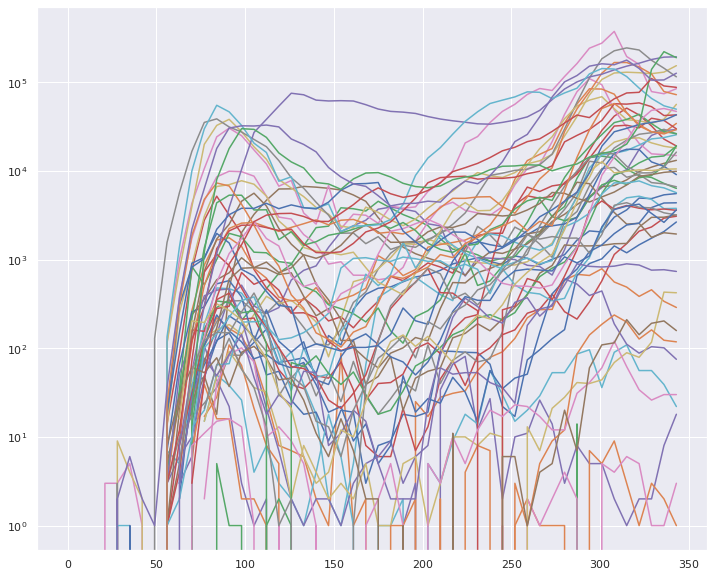

In [31]:
for (country,dfExtract) in dtg :
       #print(f"{country:30}\t-> data over {dfExtract.shape[0]} days")
       PLT.plot( dfExtract.loc[:,["elapsedDays"]], dfExtract.loc[:,["cases_weekly"]])
       PLT.yscale("log")
       #painter = figureTSFromFrame(dfExtract.loc[:,["cases","deaths"]],figsize=(12,8))
       #painter.doPlot()

In [32]:
dtx = dt[ (dt.index == "Europe") & (dt["popData2019"] > 10.0e6) ]
dtg = dtx.groupby("countriesAndTerritories")
subnodeSpec=(lambda i,j:{"nrows":i,"ncols":j})(*subPlotShape(len(dtg),maxCol=4))

Country=Azerbaijan, pop:10.047719M
Country=Belgium, pop:11.455519M
Country=Czechia, pop:10.6498M
Country=France, pop:67.012883M
Country=Germany, pop:83.019213M
Country=Greece, pop:10.724599M
Country=Italy, pop:60.359546M
Country=Netherlands, pop:17.282163M
Country=Poland, pop:37.972812M
Country=Portugal, pop:10.276617M
Country=Romania, pop:19.414458M
Country=Russia, pop:145.87226M
Country=Spain, pop:46.93706M
Country=Sweden, pop:10.230185M
Country=Turkey, pop:82.003882M
Country=Ukraine, pop:43.993643M
Country=United_Kingdom, pop:66.647112M
Saving figure FIG007


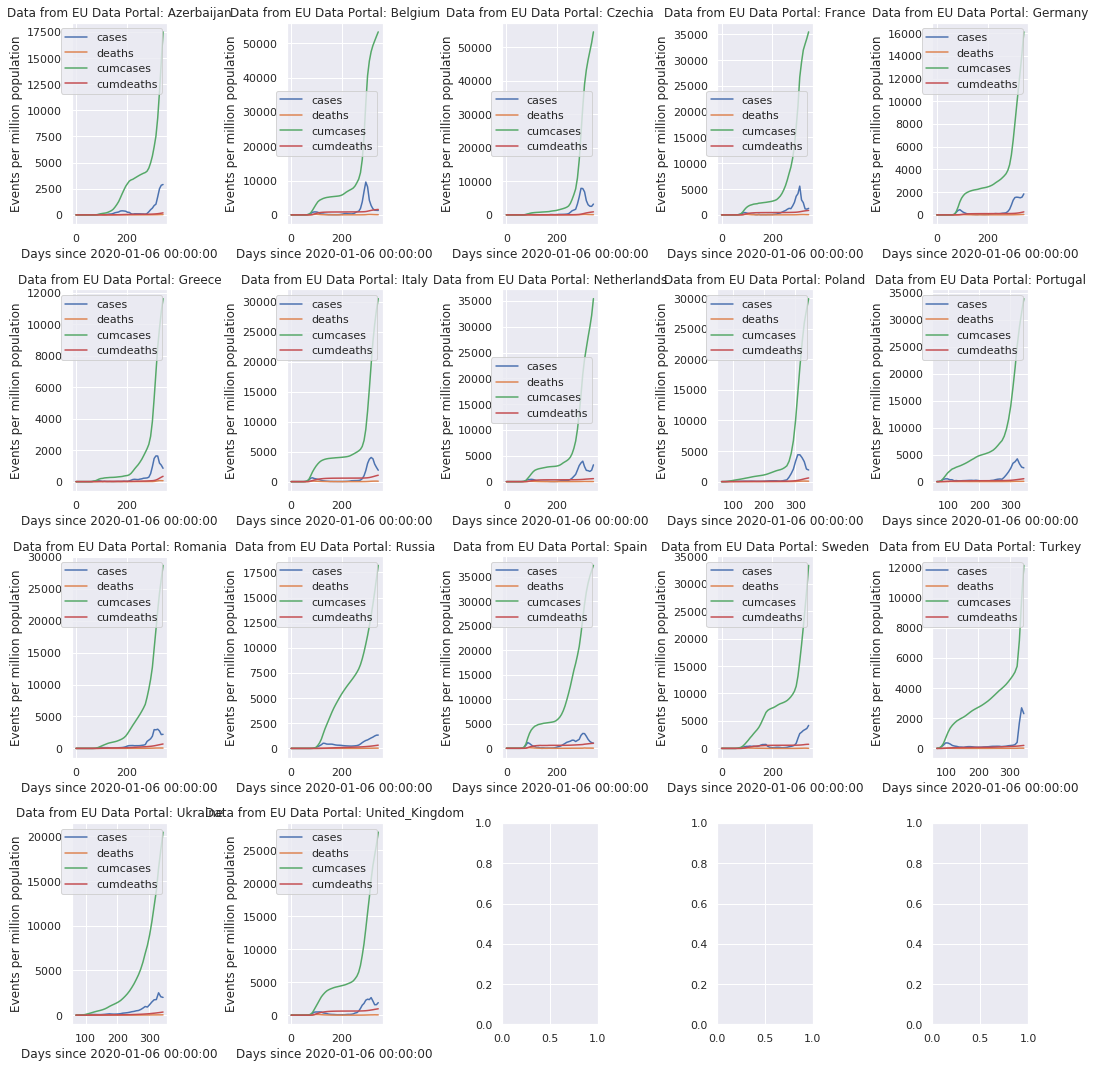

In [37]:
painter = figureFromFrame(None, subplots=subnodeSpec, figsize=(15,15))
for (country,dfExtractOrig) in dtg :
    pop = dfExtractOrig["popData2019"][0]
    print(f"Country={country}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumcases"] = dfExtract.loc[:,"cases_weekly"].sort_index().cumsum()/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"deaths_weekly"].sort_index().cumsum()/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"cases"] = dfExtract.loc[:,"cases_weekly"]/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"deaths_weekly"]/dfExtract.loc[:,"popData2019"]*1.0E6
    painter.doPlot(df = dfExtract.loc[:,["cases","deaths","cumcases","cumdeaths"]])
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from EU Data Portal: {country}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
        
    painter.advancePlotIndex()  
ImgMgr.save_fig("FIG007")  

Country=Azerbaijan, pop:10.047719M
Country=Belgium, pop:11.455519M
Country=Czechia, pop:10.6498M
Country=France, pop:67.012883M
Country=Germany, pop:83.019213M
Country=Greece, pop:10.724599M
Country=Italy, pop:60.359546M
Country=Netherlands, pop:17.282163M
Country=Poland, pop:37.972812M
Country=Portugal, pop:10.276617M
Country=Romania, pop:19.414458M
Country=Russia, pop:145.87226M
Country=Spain, pop:46.93706M
Country=Sweden, pop:10.230185M
Country=Turkey, pop:82.003882M
Country=Ukraine, pop:43.993643M
Country=United_Kingdom, pop:66.647112M
Saving figure FIG017


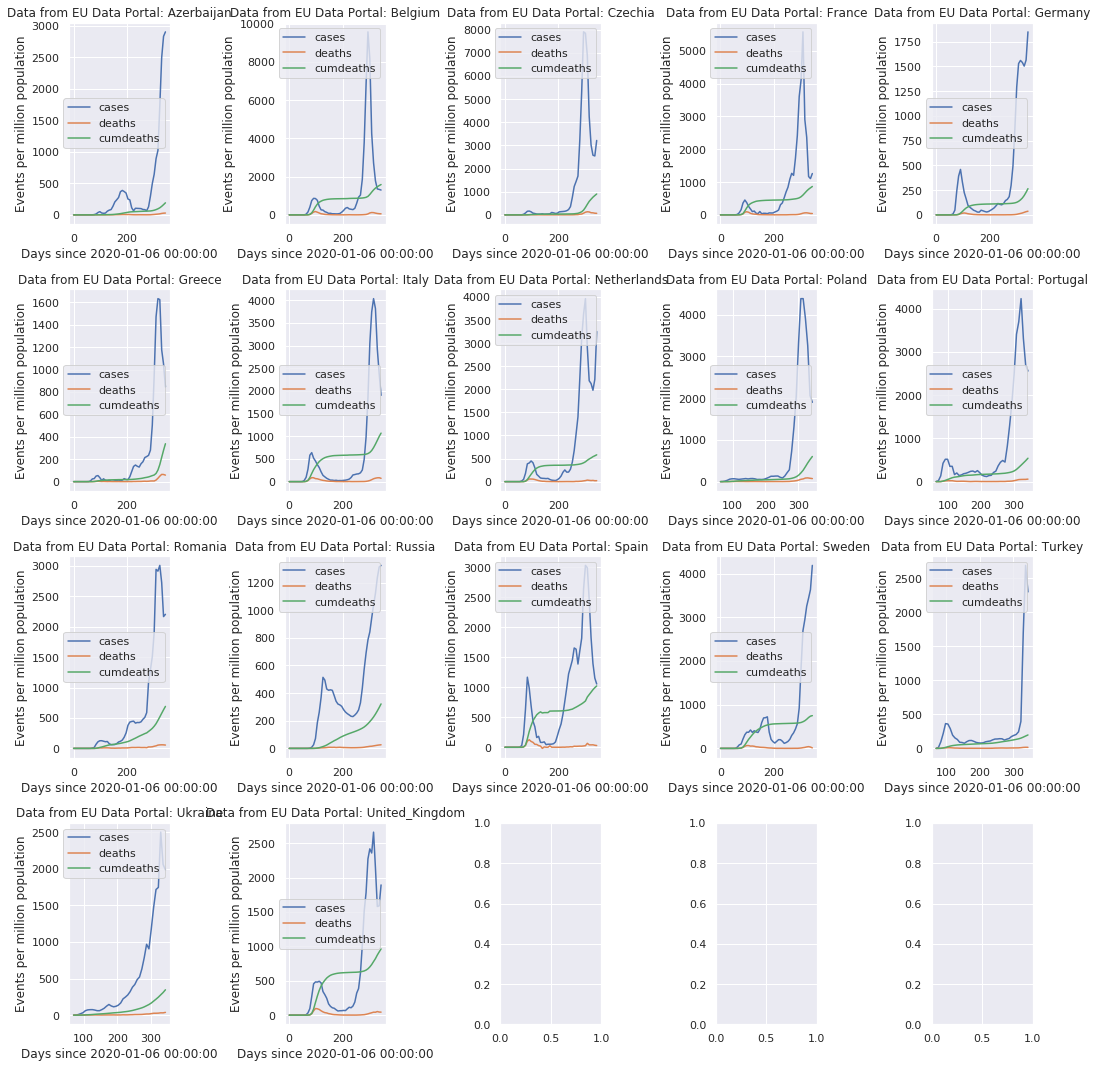

In [36]:
painter = figureFromFrame(None, subplots=subnodeSpec, figsize=(15,15))
for (country,dfExtractOrig) in dtg :
    pop = dfExtractOrig["popData2019"][0]
    print(f"Country={country}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"deaths_weekly"].sort_index().cumsum()/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"cases"] = dfExtract.loc[:,"cases_weekly"]/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"deaths_weekly"]/dfExtract.loc[:,"popData2019"]*1.0E6
    painter.doPlot(df = dfExtract.loc[:,["cases","deaths","cumdeaths"]])
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from EU Data Portal: {country}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
        
    painter.advancePlotIndex()  
ImgMgr.save_fig("FIG017")  

Country=Azerbaijan, pop:10.047719M
Country=Belgium, pop:11.455519M
Country=Czechia, pop:10.6498M
Country=France, pop:67.012883M
Country=Germany, pop:83.019213M
Country=Greece, pop:10.724599M
Country=Italy, pop:60.359546M
Country=Netherlands, pop:17.282163M
Country=Poland, pop:37.972812M
Country=Portugal, pop:10.276617M
Country=Romania, pop:19.414458M
Country=Russia, pop:145.87226M
Country=Spain, pop:46.93706M
Country=Sweden, pop:10.230185M
Country=Turkey, pop:82.003882M
Country=Ukraine, pop:43.993643M
Country=United_Kingdom, pop:66.647112M
Saving figure FIG008


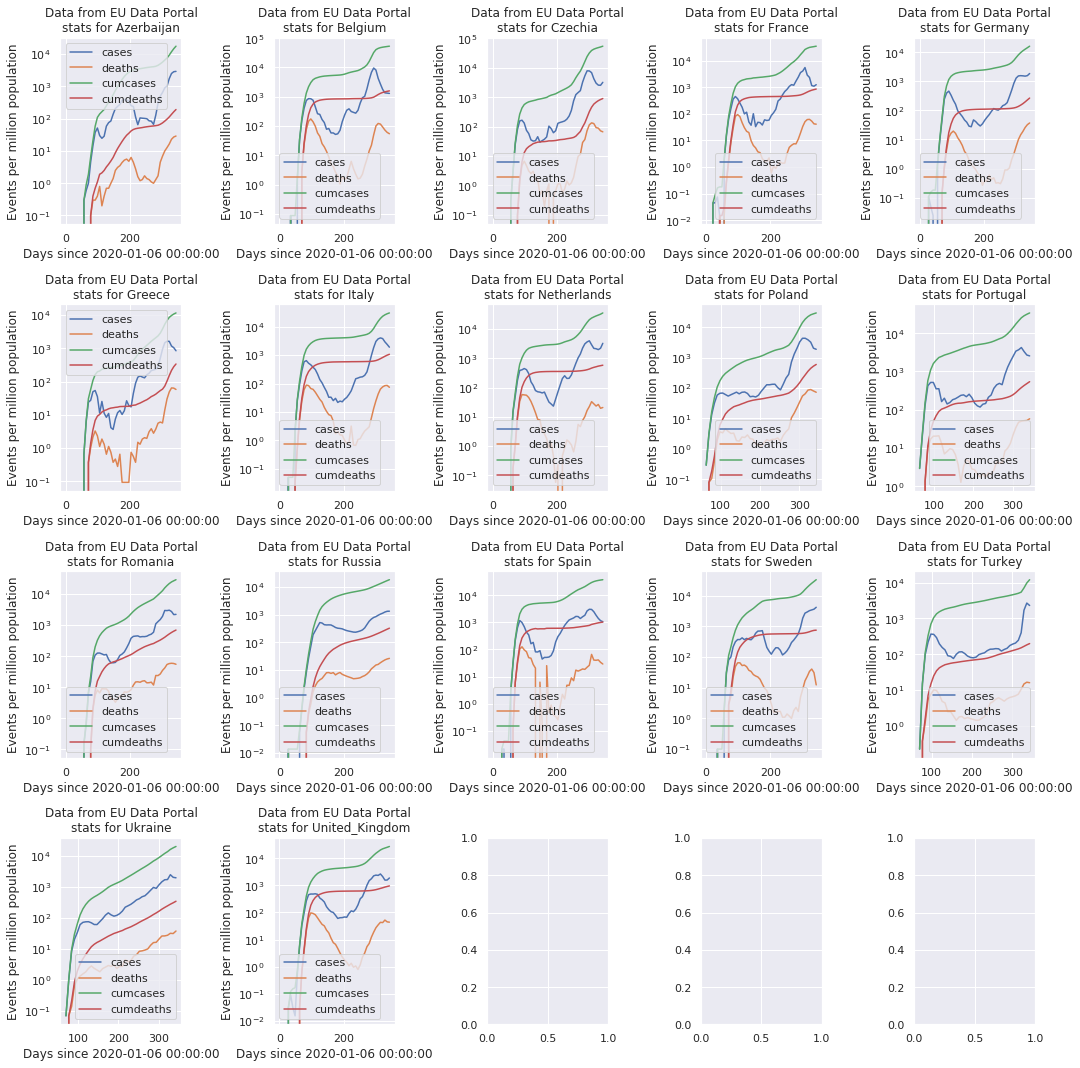

In [39]:
painter = figureFromFrame(None,  subplots=subnodeSpec, figsize=(15,15))
for (country,dfExtractOrig) in dtg :
    pop = dfExtractOrig["popData2019"][0]
    print(f"Country={country}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumcases"] = dfExtract.loc[:,"cases_weekly"].sort_index().cumsum()/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"deaths_weekly"].sort_index().cumsum()/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"cases"] = dfExtract.loc[:,"cases_weekly"]/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"deaths_weekly"]/dfExtract.loc[:,"popData2019"]*1.0E6
    painter.doPlot( df = dfExtract.loc[:,["cases","deaths","cumcases","cumdeaths"]],
                      colOpts={"cases": {"yscale":'log'},
                            "deaths": {"yscale":'log'},
                            "cumcases": {"yscale":'log'},
                            "cumdeaths": {"yscale":'log'},})
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from EU Data Portal\nstats for {country}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
    painter.advancePlotIndex()
ImgMgr.save_fig("FIG008")        

### Look at the largest countries

In [ ]:
dtx = dt[ dt["popData2019"] > 65.0e6 ]
dtg = dtx.groupby("countriesAndTerritories")
subnodeSpec=(lambda i,j:{"nrows":i,"ncols":j})(*subPlotShape(len(dtg),maxCol=4, colFirst=False))

Country=Azerbaijan, pop:10.047719M
Country=Belgium, pop:11.455519M
Country=Czechia, pop:10.6498M
Country=France, pop:67.012883M
Country=Germany, pop:83.019213M
Country=Greece, pop:10.724599M
Country=Italy, pop:60.359546M
Country=Netherlands, pop:17.282163M
Country=Poland, pop:37.972812M
Country=Portugal, pop:10.276617M
Country=Romania, pop:19.414458M
Country=Russia, pop:145.87226M
Country=Spain, pop:46.93706M
Country=Sweden, pop:10.230185M
Country=Turkey, pop:82.003882M
Country=Ukraine, pop:43.993643M
Country=United_Kingdom, pop:66.647112M
Saving figure FIG009


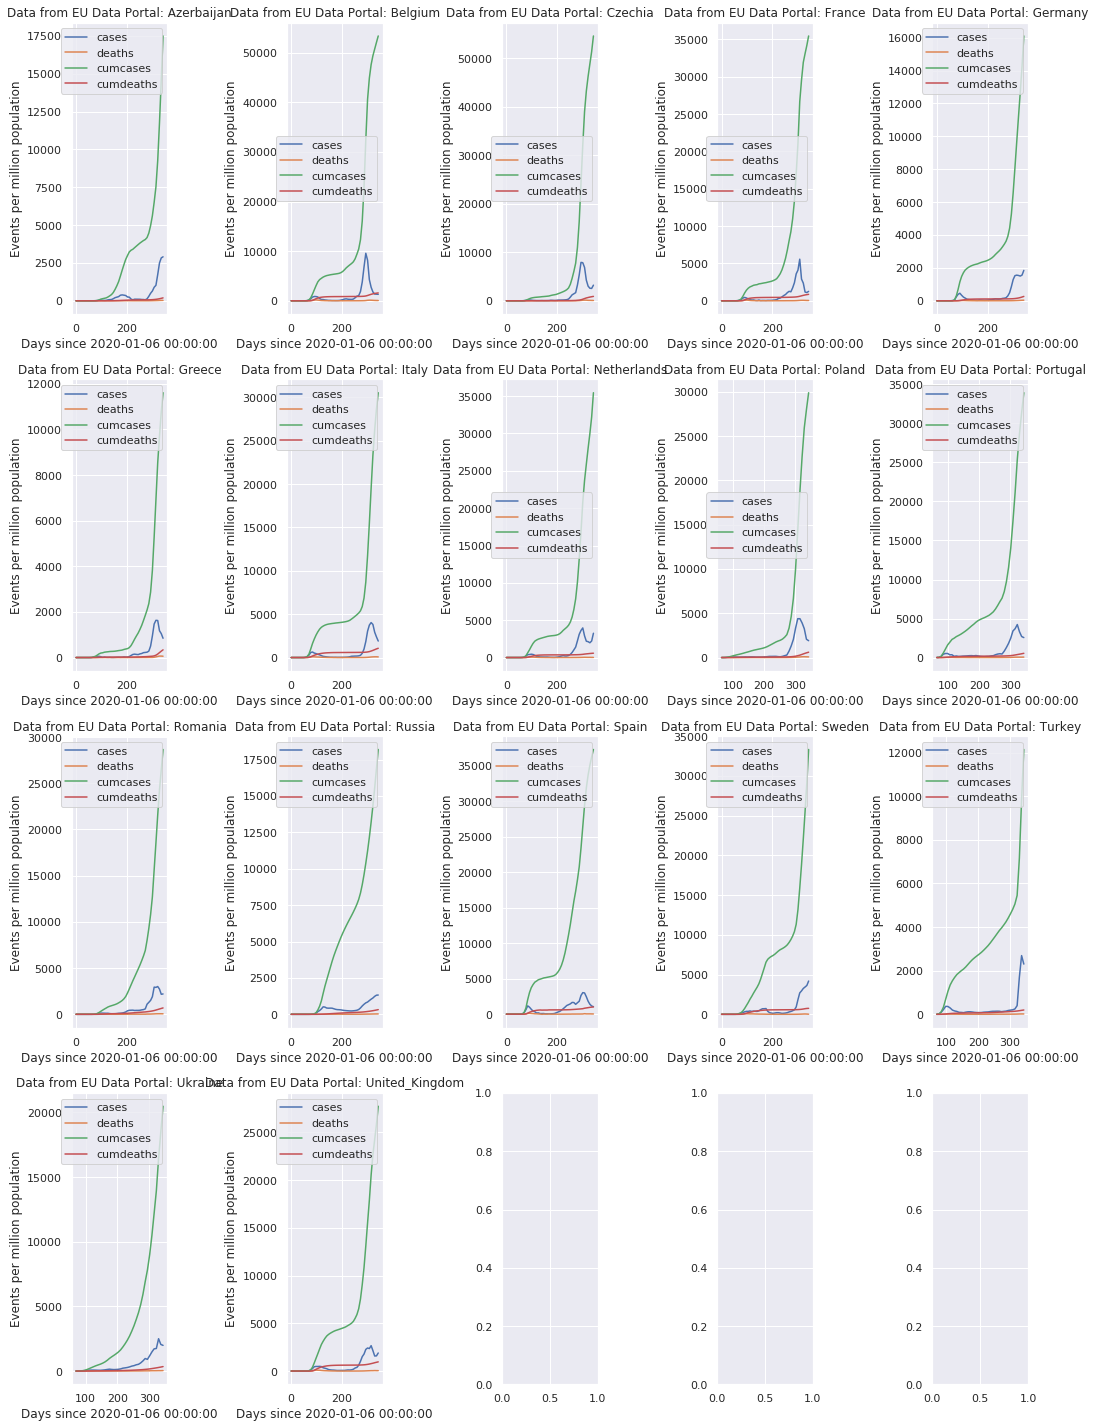

In [40]:
painter = figureFromFrame(None, subplots=subnodeSpec, figsize=(15,20))
for (country,dfExtractOrig) in dtg :
    pop = dfExtractOrig["popData2019"][0]
    print(f"Country={country}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumcases"] = dfExtract.loc[:,"cases_weekly"].sort_index().cumsum()/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"deaths_weekly"].sort_index().cumsum()/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"cases"] = dfExtract.loc[:,"cases_weekly"]/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"deaths_weekly"]/dfExtract.loc[:,"popData2019"]*1.0E6
    painter.doPlot(df = dfExtract.loc[:,["cases","deaths","cumcases","cumdeaths"]])
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from EU Data Portal: {country}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
        
    painter.advancePlotIndex()  
ImgMgr.save_fig("FIG009")  

Country=Azerbaijan, pop:10.047719M
Country=Belgium, pop:11.455519M
Country=Czechia, pop:10.6498M
Country=France, pop:67.012883M
Country=Germany, pop:83.019213M
Country=Greece, pop:10.724599M
Country=Italy, pop:60.359546M
Country=Netherlands, pop:17.282163M
Country=Poland, pop:37.972812M
Country=Portugal, pop:10.276617M
Country=Romania, pop:19.414458M
Country=Russia, pop:145.87226M
Country=Spain, pop:46.93706M
Country=Sweden, pop:10.230185M
Country=Turkey, pop:82.003882M
Country=Ukraine, pop:43.993643M
Country=United_Kingdom, pop:66.647112M
Saving figure FIG019


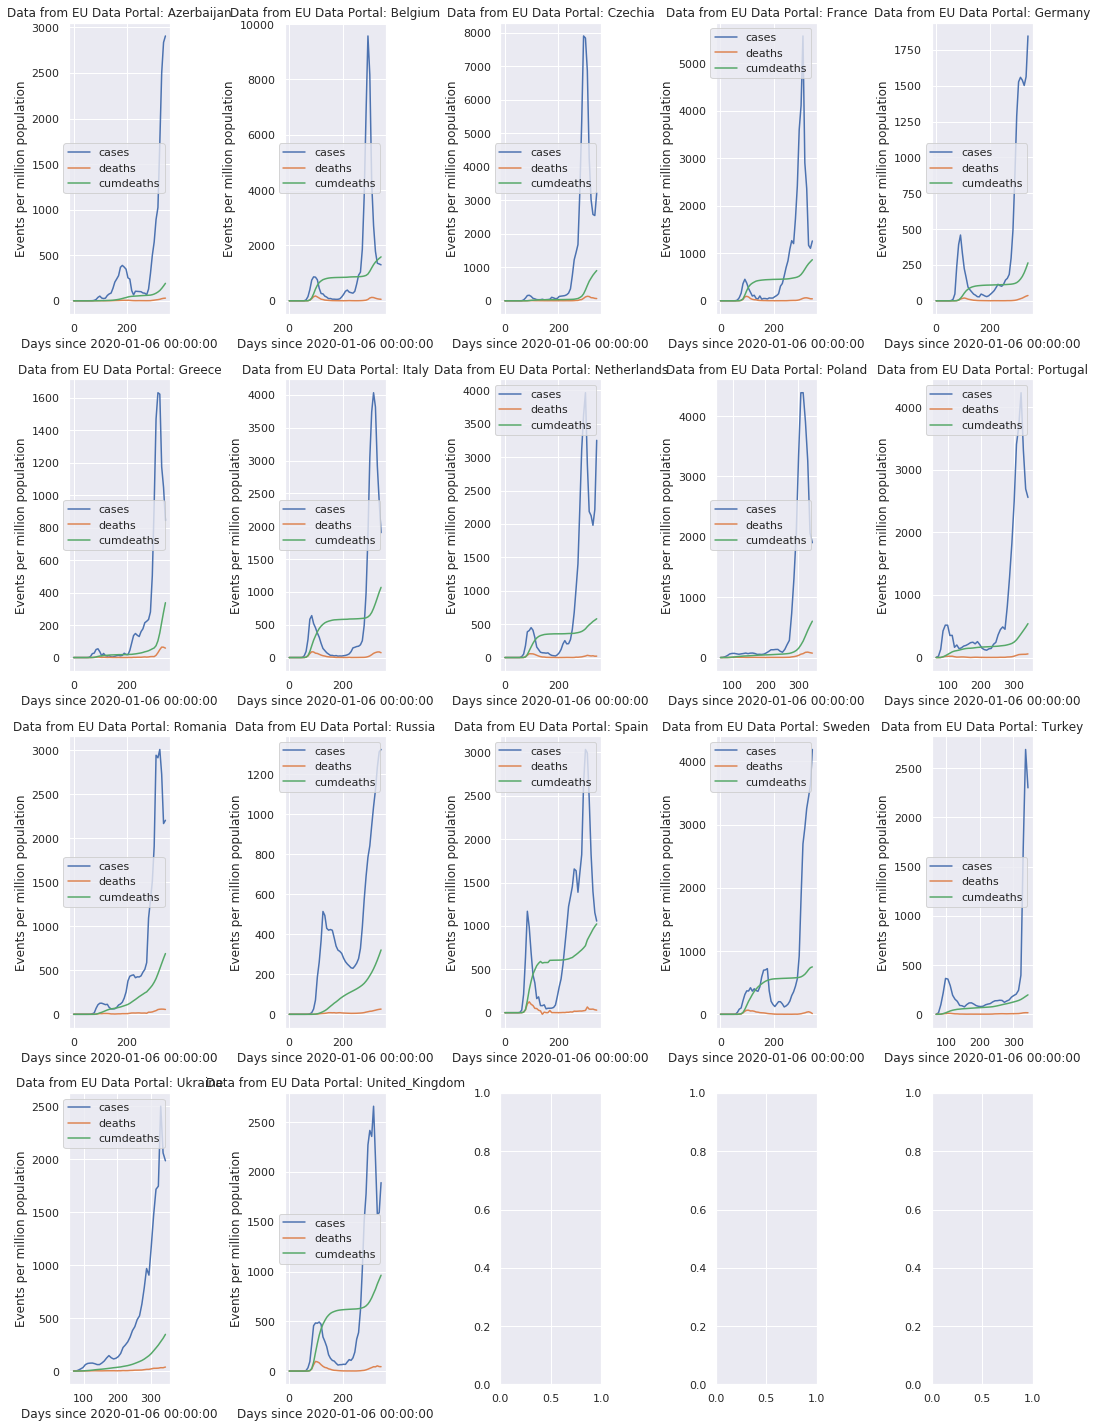

In [41]:
painter = figureFromFrame(None, subplots=subnodeSpec, figsize=(15,20))
for (country,dfExtractOrig) in dtg :
    pop = dfExtractOrig["popData2019"][0]
    print(f"Country={country}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"deaths_weekly"].sort_index().cumsum()/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"cases"] = dfExtract.loc[:,"cases_weekly"]/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"deaths_weekly"]/dfExtract.loc[:,"popData2019"]*1.0E6
    painter.doPlot(df = dfExtract.loc[:,["cases","deaths","cumdeaths"]])
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from EU Data Portal: {country}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
        
    painter.advancePlotIndex()  
ImgMgr.save_fig("FIG019")  

Country=Azerbaijan, pop:10.047719M
Country=Belgium, pop:11.455519M
Country=Czechia, pop:10.6498M
Country=France, pop:67.012883M
Country=Germany, pop:83.019213M
Country=Greece, pop:10.724599M
Country=Italy, pop:60.359546M
Country=Netherlands, pop:17.282163M
Country=Poland, pop:37.972812M
Country=Portugal, pop:10.276617M
Country=Romania, pop:19.414458M
Country=Russia, pop:145.87226M
Country=Spain, pop:46.93706M
Country=Sweden, pop:10.230185M
Country=Turkey, pop:82.003882M
Country=Ukraine, pop:43.993643M
Country=United_Kingdom, pop:66.647112M
Saving figure FIG010


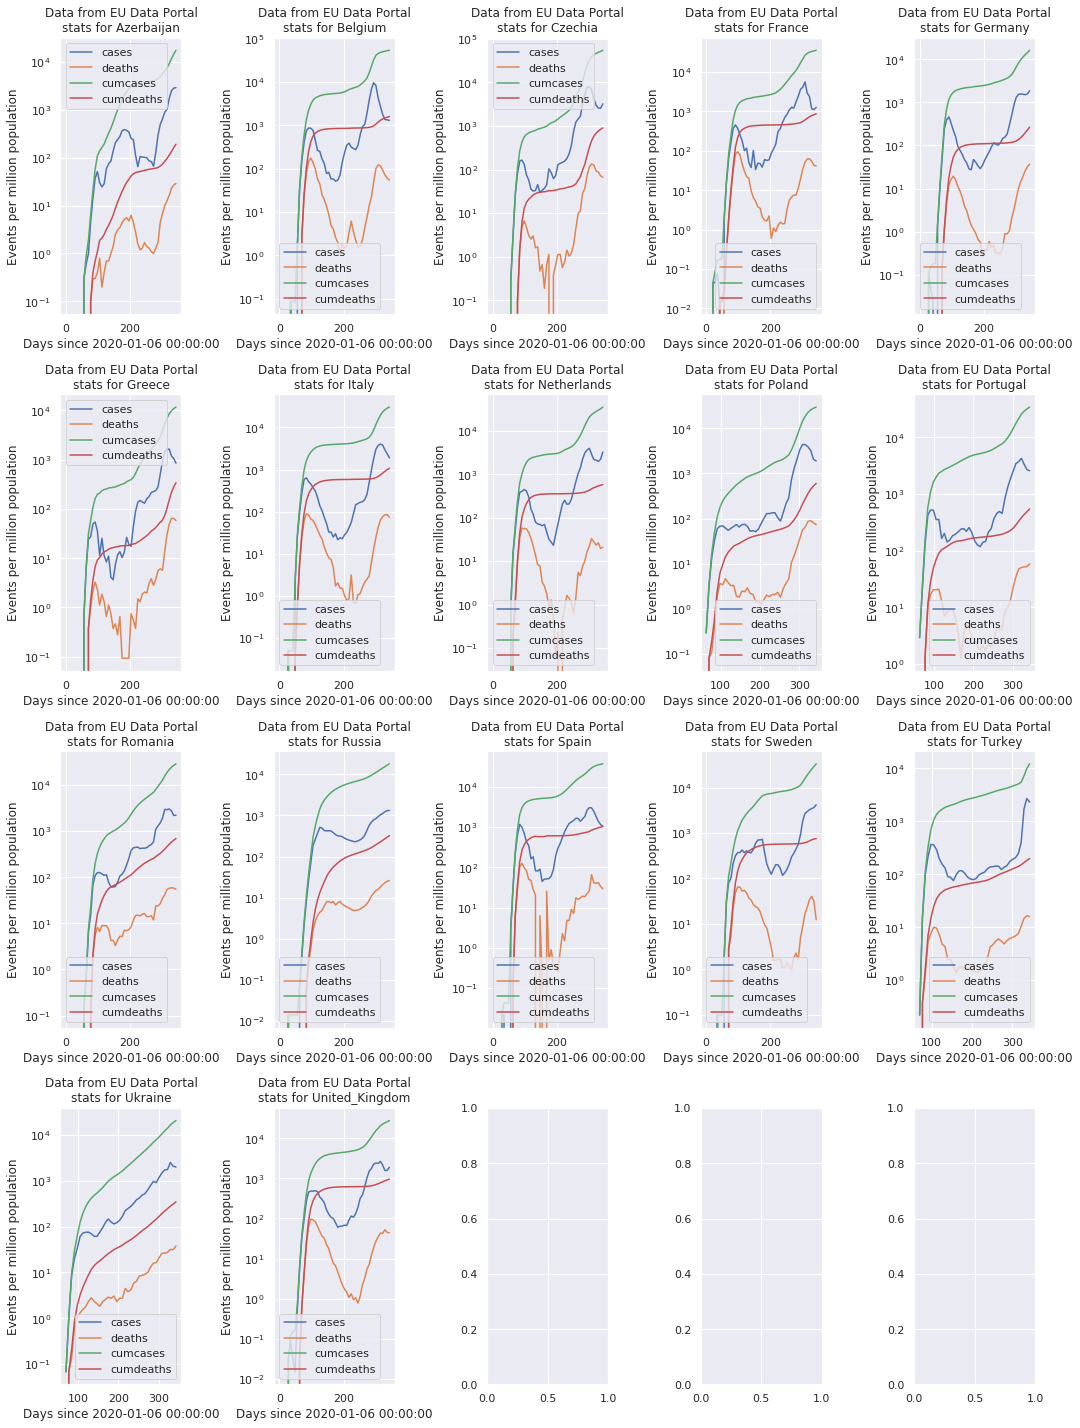

In [42]:
painter = figureFromFrame(None,  subplots=subnodeSpec, figsize=(15,20))
for (country,dfExtractOrig) in dtg :
    pop = dfExtractOrig["popData2019"][0]
    print(f"Country={country}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumcases"] = dfExtract.loc[:,"cases_weekly"].sort_index().cumsum()/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"deaths_weekly"].sort_index().cumsum()/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"cases"] = dfExtract.loc[:,"cases_weekly"]/dfExtract.loc[:,"popData2019"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"deaths_weekly"]/dfExtract.loc[:,"popData2019"]*1.0E6
    painter.doPlot( df = dfExtract.loc[:,["cases","deaths","cumcases","cumdeaths"]],
                      colOpts={"cases": {"yscale":'log'},
                            "deaths": {"yscale":'log'},
                            "cumcases": {"yscale":'log'},
                            "cumdeaths": {"yscale":'log'},})
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from EU Data Portal\nstats for {country}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
    painter.advancePlotIndex()
ImgMgr.save_fig("FIG010")        